In [2]:
from torchvision import datasets, transforms, models
import tqdm.notebook as tq
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sn
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
model, preprocess = clip.load("ViT-B/32")

In [3]:
def text_embeddings(class_list, phrase="This is a photo of {}",norm=True):
    """Generates embeddings for a list of label names/classes"""
    embs = []
    for c in class_list:
        text = phrase.format(c)
        texts = clip.tokenize(text).cuda()
        class_embeddings = model.encode_text(texts)
        if norm:
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        if norm:
            class_embedding /= class_embedding.norm()
        embs.append(class_embedding.cpu().detach().numpy())
    return embs

Euclidean distance between Flower embeddings
0.8467103318117506


<AxesSubplot:>

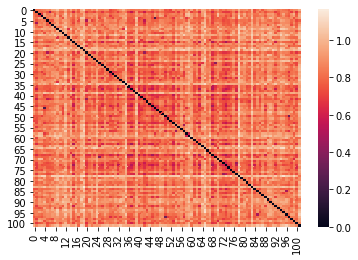

In [4]:
flowers_classes = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]
flowers_text_embeddings = text_embeddings(flowers_classes, phrase="This is a photo of {}, a kind of flower.")
flowers_text_sim_matrix = euclidean_distances(flowers_text_embeddings)
print("Euclidean distance between Flower embeddings")
print(flowers_text_sim_matrix.mean())
sn.heatmap(flowers_text_sim_matrix)

Euclidean distance between Flower embeddings - No normalization
Mean : 6.693172202231734


<AxesSubplot:>

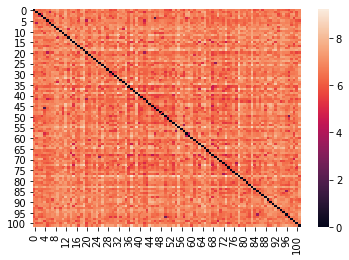

In [5]:
flowers_text_embeddings_unnorm = text_embeddings(flowers_classes, phrase="This is a photo of {}, a kind of flower.",norm=False)
flowers_text_unnorm_sim_matrix = euclidean_distances(flowers_text_embeddings_unnorm)
print("Euclidean distance between Flower embeddings - No normalization")
print("Mean :",flowers_text_unnorm_sim_matrix.mean())
sn.heatmap(flowers_text_unnorm_sim_matrix)

Files already downloaded and verified
Euclidean distance between CIFAR100 embeddings
0.6304094970167805


<AxesSubplot:>

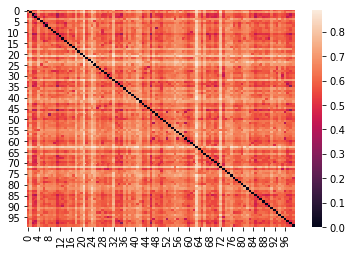

In [6]:
from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(
    root="/nethome/bdevnani3/raid/data/",
    train=True,
    download=True,
)
cifar_classes = cifar100.classes

cifar_text_embeddings = text_embeddings(cifar_classes, phrase="This is a photo of {}.")
cifar_text_sim_matrix = euclidean_distances(cifar_text_embeddings)
print("Euclidean distance between CIFAR100 embeddings")
print(cifar_text_sim_matrix.mean())
sn.heatmap(cifar_text_sim_matrix)

Euclidean distance between CIFAR embeddings - No normalization
Mean : 6.398207509103637


<AxesSubplot:>

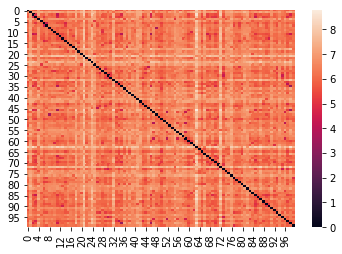

In [7]:
cifar_text_unnorm_embeddings = text_embeddings(cifar_classes, phrase="This is a photo of {}.", norm=False)
cifar_text_unnorm_sim_matrix = euclidean_distances(cifar_text_unnorm_embeddings)
print("Euclidean distance between CIFAR embeddings - No normalization")
print("Mean :",cifar_text_unnorm_sim_matrix.mean())
sn.heatmap(cifar_text_unnorm_sim_matrix)

This is pretty odd. The relative distances between the embeddings of the classes seem quite similar for CIFAR100 vs Flowers dataset, even though flowers performs significantly worse in zero shot. This rules out the hypothesis that the maximizing the distances between the embeddings will actually work.

Maybe explore image features?

In [145]:
from torchvision import datasets, transforms, models
test_transform = transforms.Compose(
            [
                transforms.Resize(256),
#                 transforms.CenterCrop(224),
                transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
train_dataset = datasets.ImageFolder(
            "/nethome/bdevnani3/raid/data/flower_data/train", transform=test_transform
        )
flowers_train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=100,
            num_workers=4,
        )

test_dataset = datasets.ImageFolder(
            "/nethome/bdevnani3/raid/data/flower_data/test", transform=test_transform
        )
flowers_test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=100,
            num_workers=4,
        )


  0%|          | 0/66 [00:00<?, ?it/s]

Euclidean distance between Flower image embeddings
Mean : 0.385252697356998


<AxesSubplot:>

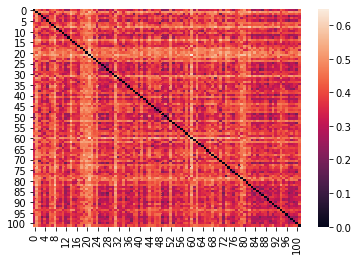

In [146]:
# Get class wise image embeddings
class_dict = {i:[] for i in range(102)}
for i, (images, targets) in enumerate(tq.tqdm(flowers_train_loader)):
    images = images.cuda()
    targets = targets.cuda()
    
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    
    for imf, target in zip(image_features,targets):
        i = float(target.cpu().detach().numpy())
        emb = imf.cpu().detach().numpy().tolist()
        class_dict[i].append(emb)
        
# Create a single embedding per class
flower_img_embs = []
for i in range(102):
    embs = class_dict[i]
    embs = np.array(embs)
    embs = np.mean(embs,axis=0)
    embs /= np.linalg.norm(embs)
    flower_img_embs.append(embs.tolist())
    
sim_matrix = euclidean_distances(flower_img_embs)
print("Euclidean distance between Flower image embeddings")
print("Mean :",sim_matrix.mean())
sn.heatmap(sim_matrix)

Cosine Similarity between Flower image vs text embeddings


<AxesSubplot:>

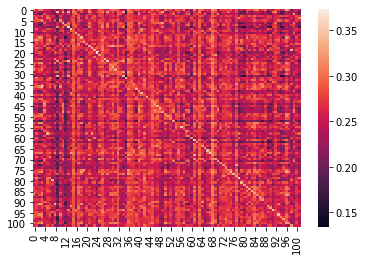

In [10]:
sim_matrix = cosine_similarity(flower_img_embs, flowers_text_embeddings)
print("Cosine Similarity between Flower image vs text embeddings")
sn.heatmap(sim_matrix)

This is even more absurd, definitely seeing some kind of line there, but not on the diagonal, are the class names incorrect?!

In [284]:
class_ind = 53

r,c = np.unravel_index(np.argsort(sim_matrix,axis=None), sim_matrix.shape)
for i in range(1,500):
    if r[-i] == class_ind:
        print(f"|{r[-i]}->{c[-i]}|")
    
ims = []
for i, (images, targets) in enumerate(tq.tqdm(flowers_test_loader)):
    images = images.cuda()
    targets = targets.cuda()
    for im, target in zip(images,targets):
        i = float(target.cpu().detach().numpy())
        if i == class_ind:
            ims.append(im.cpu().detach().permute(1, 2, 0))


  0%|          | 0/9 [00:00<?, ?it/s]

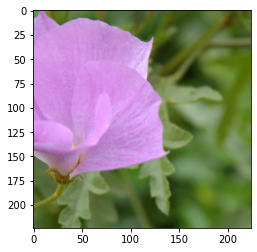

In [286]:
import random
plt.imshow(random.choice(ims))

In [266]:
i = 0
for c in flowers_classes:
    i+=1
    if c not in new_flowers_dict:
        print(c)

monkshood
grape hyacinth
pelargonium
mallow


In [288]:
new_flowers_dict = {
'pink primrose': 0,
 'globe thistle': 1,
 'blanket flower': 2,
 'trumpet creeper': 3,
 'blackberry lily': 4,
 'snapdragon': 5,
 "colt's foot": 6,
 'king protea': 7,
 'spear thistle': 8,
 'yellow iris': 9,
 'globe-flower': 10,
 'purple coneflower': 11,
 'peruvian lily': 12,
 'balloon flower': 13,
 'hard-leaved pocket orchid': 14,
 'giant white arum lily': 15,
 'fire lily': 16,
 'pincushion flower': 17,
 'fritillary': 18,
 'red ginger': 19,
 'grape hyacinth': 20,
 'corn poppy': 21,
 'prince of wales feathers': 22,
 'stemless gentian': 23,
 'artichoke': 24,
 'canterbury bells': 25,
 'sweet william': 26,
 'carnation': 27,
 'garden phlox': 28,
 'love in the mist': 29,
 'mexican aster': 30,
 'alpine sea holly': 31,
 'ruby-lipped cattleya': 32,
 'cape flower': 33,
 'great masterwort': 34,
 'siam tulip': 35,
 'sweet pea': 36,
 'lenten rose': 37,
 'barbeton daisy': 38,
 'daffodil': 39,
 'sword lily': 40,
 'poinsettia': 41,
 'bolero deep blue': 42,
 'wallflower': 43,
 'marigold': 44,
 'buttercup': 45,
 'oxeye daisy': 46,
 'english marigold': 47,
 'common dandelion': 48,
 'petunia': 49,
 'wild pansy': 50,
 'primula': 51,
 'sunflower': 52,
 'pelargonium': 53,
 'bishop of llandaff': 54,
 'gaura': 55,
 'geranium': 56,
 'orange dahlia': 57,
 'tiger lily': 58,
 'pink-yellow dahlia': 59,
 'cautleya spicata': 60,
 'japanese anemone': 61,
 'black-eyed susan': 62,
 'silverbush': 63,
 'californian poppy': 64,
 'osteospermum': 65,
 'spring crocus': 66,
 'bearded iris': 67,
 'windflower': 68,
 'moon orchid': 69,
 'tree poppy': 70,
 'gazania': 71,
 'azalea': 72,
 'water lily': 73,
 'rose': 74,
 'thorn apple': 75,
 'morning glory': 76,
 'passion flower': 77,
 'lotus': 78,
 'toad lily': 79,
 'bird of paradise': 80,
 'anthurium': 81,
 'frangipani': 82,
 'clematis': 83,
 'hibiscus': 84,
 'columbine': 85,
 'desert-rose': 86,
 'tree mallow': 87,
 'magnolia': 88,
 'cyclamen': 89,
 'watercress': 90,
 'monkshood': 91,
 'canna lily': 92,
 'hippeastrum': 93,
 'bee balm': 94,
 'ball moss': 95,
 'foxglove': 96,
 'bougainvillea': 97,
 'camellia': 98,
 'mallow': 99,
 'mexican petunia': 100,
 'bromelia': 101
 }

In [290]:
keys = []
for k,v in new_flowers_dict.items():
    keys.append(k)

In [291]:
keys

['pink primrose',
 'globe thistle',
 'blanket flower',
 'trumpet creeper',
 'blackberry lily',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'hard-leaved pocket orchid',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'canterbury bells',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'sweet pea',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'english marigold',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',
 'gera

Seems like the embeddings were incorrect after all! This above is the corrected version.

In [292]:
import json
json_object = json.dumps(new_flowers_dict, indent = 4)  
print(json_object) 

{
    "pink primrose": 0,
    "globe thistle": 1,
    "blanket flower": 2,
    "trumpet creeper": 3,
    "blackberry lily": 4,
    "snapdragon": 5,
    "colt's foot": 6,
    "king protea": 7,
    "spear thistle": 8,
    "yellow iris": 9,
    "globe-flower": 10,
    "purple coneflower": 11,
    "peruvian lily": 12,
    "balloon flower": 13,
    "hard-leaved pocket orchid": 14,
    "giant white arum lily": 15,
    "fire lily": 16,
    "pincushion flower": 17,
    "fritillary": 18,
    "red ginger": 19,
    "grape hyacinth": 20,
    "corn poppy": 21,
    "prince of wales feathers": 22,
    "stemless gentian": 23,
    "artichoke": 24,
    "canterbury bells": 25,
    "sweet william": 26,
    "carnation": 27,
    "garden phlox": 28,
    "love in the mist": 29,
    "mexican aster": 30,
    "alpine sea holly": 31,
    "ruby-lipped cattleya": 32,
    "cape flower": 33,
    "great masterwort": 34,
    "siam tulip": 35,
    "sweet pea": 36,
    "lenten rose": 37,
    "barbeton daisy": 38,
    "da